<a href="https://colab.research.google.com/github/cemdenizsel/Financial-Sentiment-Analysis-with-Transformer-Based-Models/blob/main/Finetuning_51K_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing transformers and importing Packages 

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 2.3MB 9.1MB/s 
     |████████████████████████████████| 901kB 47.9MB/s 
     |████████████████████████████████| 3.3MB 46.6MB/s 


In [ ]:
import transformers
from transformers import AutoTokenizer
from transformers import BertConfig, BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch.functional import F

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
!gdown --id 1QcghzN11u3Ir0L1Nq5IuGmOZeLXn3Zgn

Downloading...
From: https://drive.google.com/uc?id=1QcghzN11u3Ir0L1Nq5IuGmOZeLXn3Zgn
To: /content/all-data.csv
100% 672k/672k [00:00<00:00, 45.1MB/s]


In [ ]:
df = pd.read_csv('all-data.csv',header=None,encoding="latin-1")
df.columns = ["sentiment", "headline"]

In [ ]:
df.head()

,sentiment,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
df.shape

(4846, 2)

In [ ]:
def sentiment_to_int(sentiment):
  if sentiment == 'negative':
    return 0
  elif sentiment == 'neutral':
    return 1
  else:
    return 2

In [ ]:
df['sentiment'] = df.sentiment.apply(sentiment_to_int)

In [ ]:
df.head()

,sentiment,headline
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


# Create Tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

## Choosing Sequence Length


In [ ]:
token_lens = []
for txt in df.headline:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


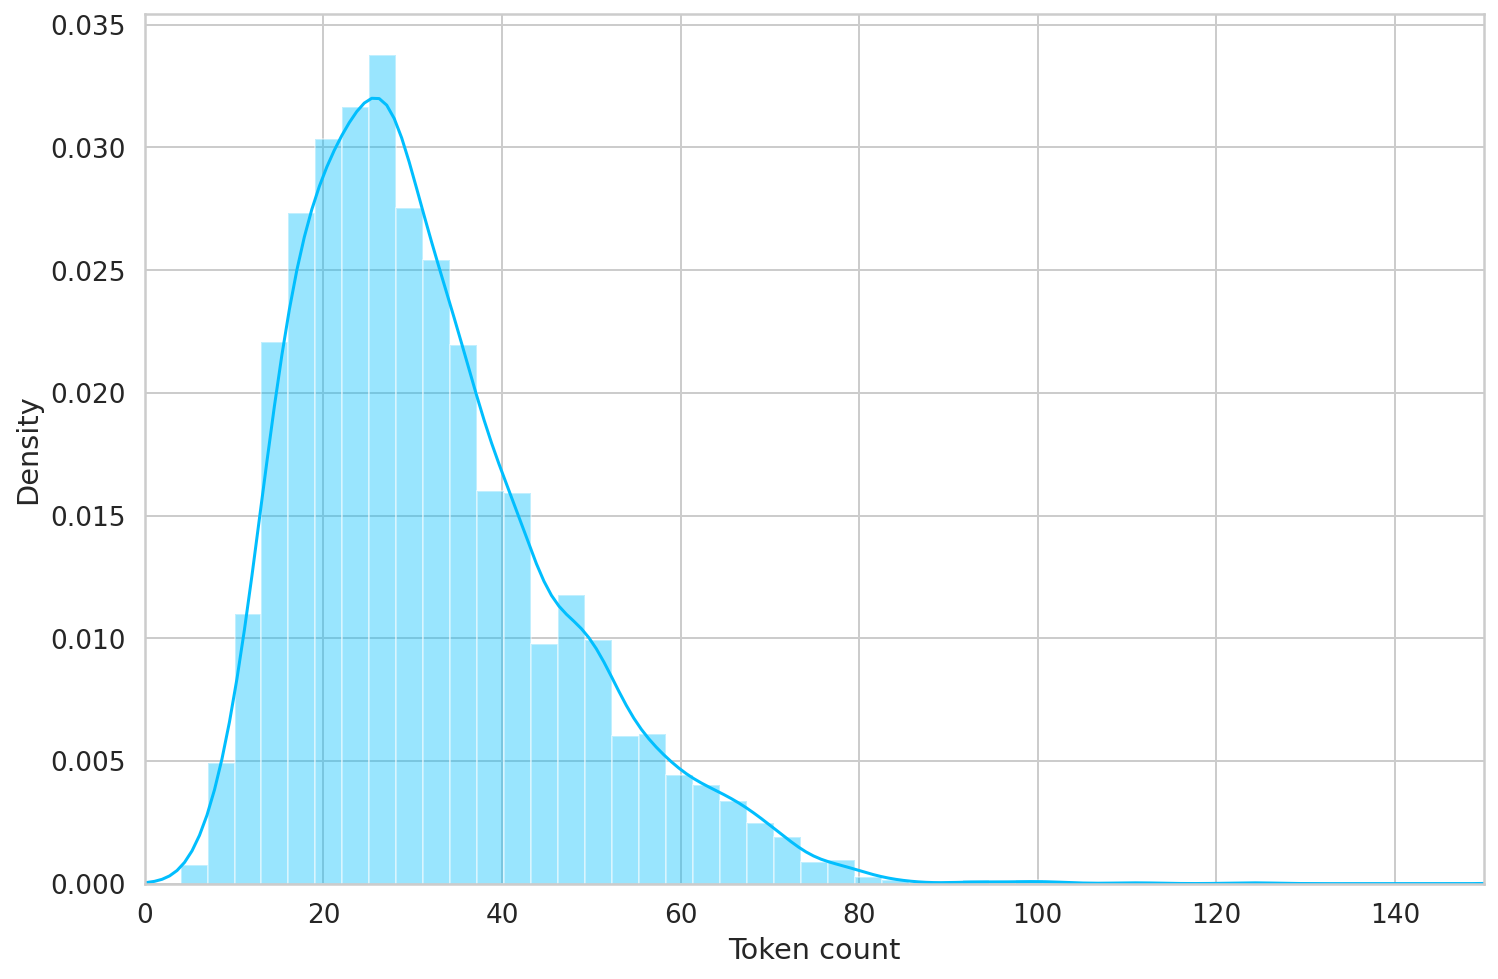

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 150]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 128

# Creating Dataset Class

In [ ]:
class FinancaDataset(Dataset):

  def __init__(self,reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self,item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return{
        'review_text':review,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
    }


# Split Dataset to Train-Val-Test

In [ ]:
df_train,df_test = train_test_split(df, test_size=0.1,random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((4361, 2), (242, 2), (243, 2))

# Create Dataloader Class

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = FinancaDataset(
      reviews= df.headline.to_numpy(),
      targets = df.sentiment.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
  )

  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers=2,
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


# Sentiment Classification with BERT


In [ ]:
from transformers import BertForSequenceClassification

bert_model = BertForSequenceClassification.from_pretrained('cemdenizsel/51k-pretrained-bert-model',num_labels = 3)
bert_model = bert_model.to(device)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
bert_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 128])
torch.Size([16, 128])


In [ ]:
EPOCHS = 6

param_optimizer = list(bert_model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

# Sanity check with one batch


In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 128])
torch.Size([16, 128])


In [ ]:
outputs = bert_model(input_ids, token_type_ids=None, attention_mask=attention_mask, labels=targets)
outputs

SequenceClassifierOutput([('loss',
                           tensor(1.0102, device='cuda:0', grad_fn=<NllLossBackward>)),
                          ('logits', tensor([[-0.1717,  0.2869, -0.0820],
                                   [-0.2035,  0.2101, -0.1214],
                                   [-0.2042,  0.3063, -0.0440],
                                   [-0.2106,  0.2524, -0.0269],
                                   [-0.1950,  0.1987,  0.0580],
                                   [-0.2430,  0.2648, -0.0872],
                                   [-0.1348,  0.2525, -0.0767],
                                   [-0.2219,  0.2986, -0.1130],
                                   [-0.1536,  0.2685, -0.0549],
                                   [-0.1824,  0.2554, -0.0815],
                                   [-0.1985,  0.2867, -0.1022],
                                   [-0.1498,  0.2236, -0.1376],
                                   [-0.2131,  0.2778, -0.1595],
                                   

# Creating training and evaluating script

In [ ]:
from sklearn import metrics
def train_epoch(
    model,
    data_loader,
    optimizer,
    device,
    scheduler,
    n_examples
):
  model = model.train()

  losses = []
  acc = 0
  counter = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
        input_ids = input_ids,
        token_type_ids=None, 
        attention_mask=attention_mask,
        labels = targets)
    loss = outputs[0]
    logits = outputs[1]

    _, prediction = torch.max(outputs[1], dim=1)
    targets = targets.cpu().detach().numpy()
    prediction = prediction.cpu().detach().numpy()
    accuracy = metrics.accuracy_score(targets, prediction)

    acc += accuracy
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    counter = counter + 1

  return acc / counter, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, device, n_examples):
  model = model.eval()

  losses = []
  acc = 0
  counter = 0

  with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, 
                            token_type_ids=None, 
                            attention_mask=attention_mask, 
                            labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

  return acc / counter, np.mean(losses)

# Training 

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
      bert_model,
      train_data_loader,
      optimizer,
      device,
      scheduler,
      len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}' )

  val_acc, val_loss = eval_model(
      bert_model, 
      val_data_loader,
      device,
      len(df_val)
  )

  print(f'Val    loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(bert_model.state_dict(), '51k-finetuned-model.bin')
    best_accuracy = val_acc

Epoch 1/6
----------
Train loss 0.9310311234041011 accuracy 0.5901760276760276
Val    loss 0.7622126378118992 accuracy 0.67578125

Epoch 2/6
----------
Train loss 0.825450572120401 accuracy 0.6418650793650793
Val    loss 0.6947873821482062 accuracy 0.72265625

Epoch 3/6
----------
Train loss 0.7179062721275148 accuracy 0.696072446072446
Val    loss 0.7443104581907392 accuracy 0.73046875

Epoch 4/6
----------
Train loss 0.598553404102832 accuracy 0.7467185592185592
Val    loss 0.7265950592700392 accuracy 0.6953125

Epoch 5/6
----------
Train loss 0.5225342680792232 accuracy 0.7773453398453398
Val    loss 0.6963652051053941 accuracy 0.73046875

Epoch 6/6
----------
Train loss 0.4605304819460099 accuracy 0.8194190069190069
Val    loss 0.7095325267291628 accuracy 0.72265625

CPU times: user 10min 13s, sys: 25 s, total: 10min 38s
Wall time: 10min 43s
Parser   : 161 ms


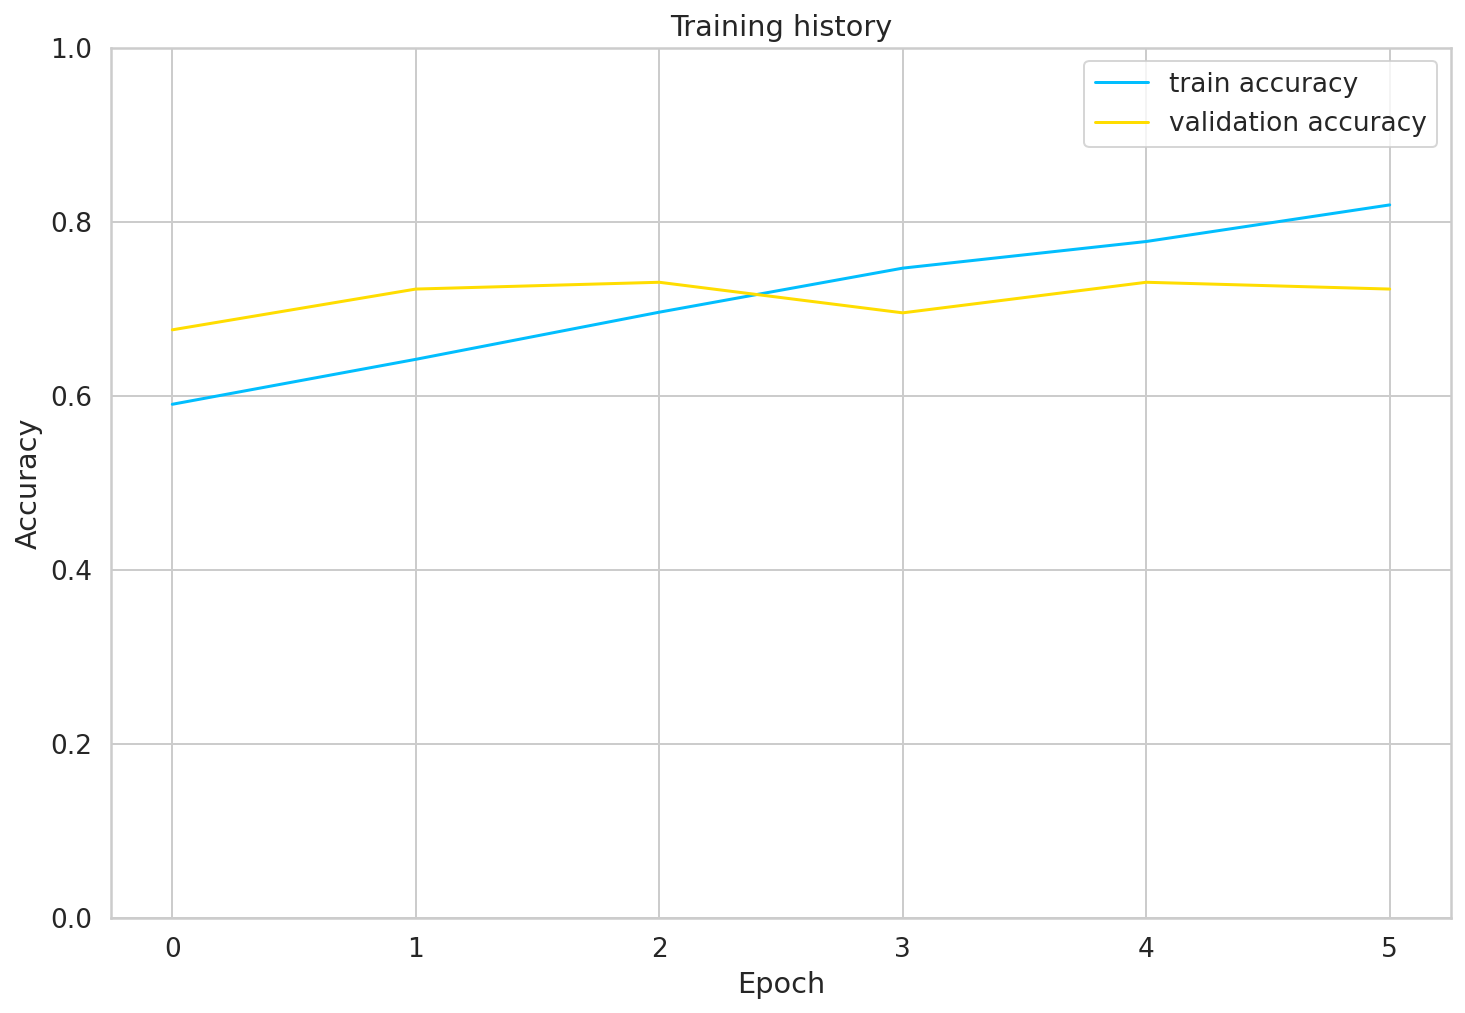

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]); 

In [ ]:
test_acc, test_loss = eval_model(
    bert_model,
    test_data_loader,
    device,
    len(df_test)
)


print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)


Test Accuracy : 0.6510416666666666
Test Loss : 1.0322663709521294


In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids,
                            token_type_ids=None,
                            attention_mask=attention_mask,
                            labels = targets)
      loss = outputs[0]
      logits = outputs[1]
                
      _, preds = torch.max(outputs[1], dim=1)

      probs = F.softmax(outputs[1], dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)
      
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  bert_model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))  

              precision    recall  f1-score   support

    negative       0.58      0.32      0.42        34
     neutral       0.72      0.82      0.77       132
    positive       0.52      0.51      0.51        77

    accuracy                           0.65       243
   macro avg       0.61      0.55      0.57       243
weighted avg       0.64      0.65      0.64       243



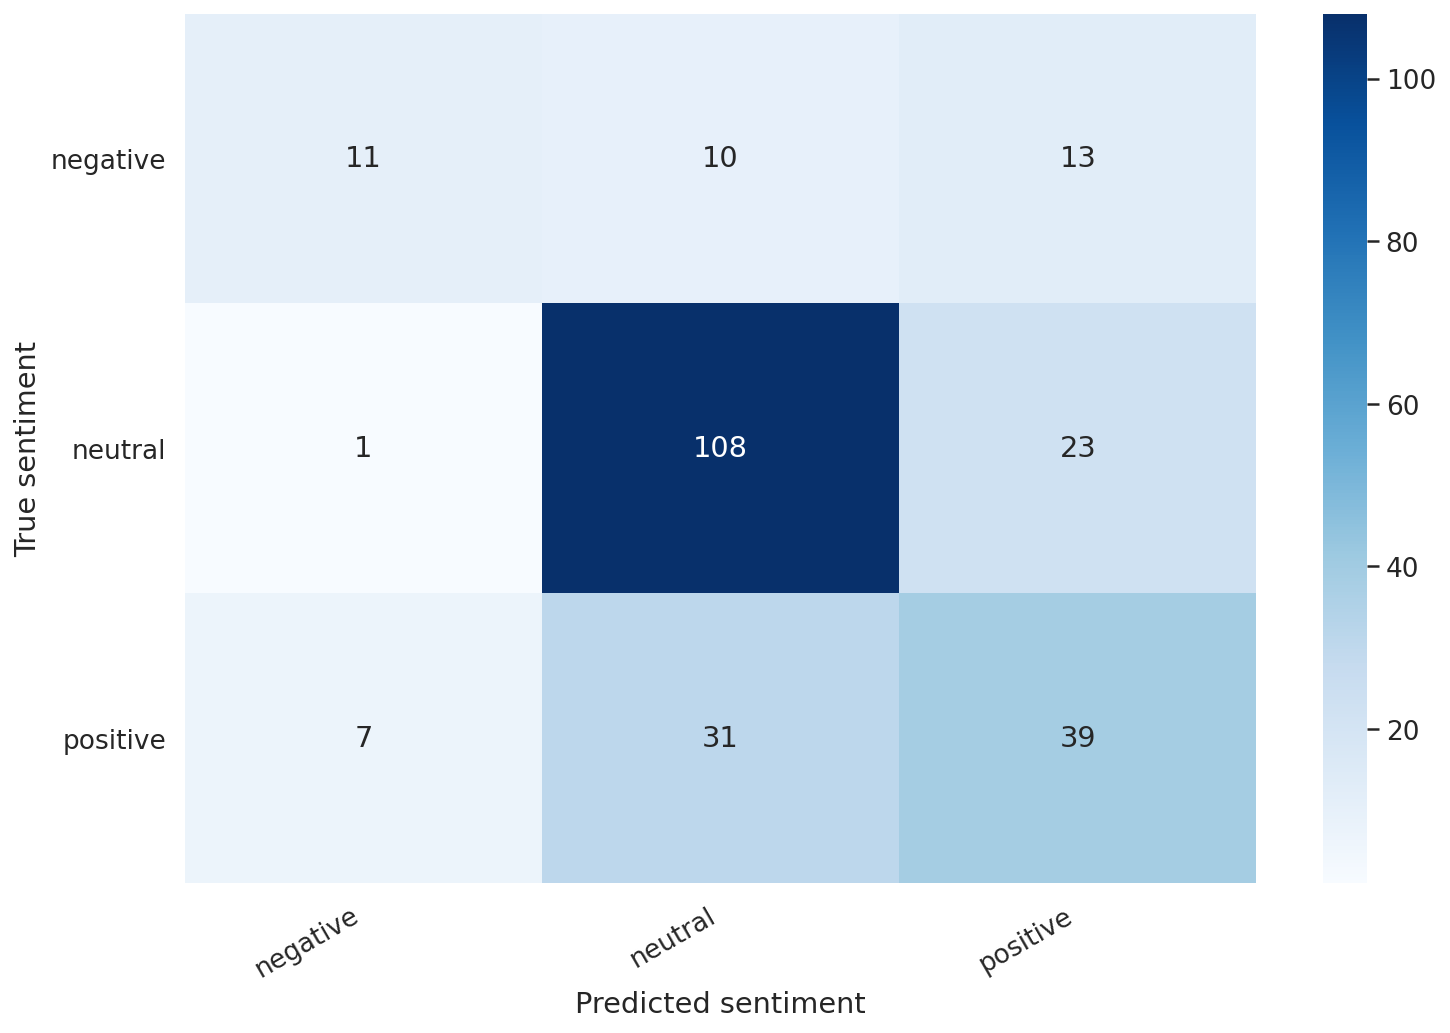

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
torch.save(bert_model,"/finetuned-model-51k-bert")

# Push Model to huggingface

In [1]:
!transformers-cli login

/bin/bash: transformers-cli: command not found


In [2]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... ^C
^C
git: 'lfs' is not a git command. See 'git --help'.

The most similar command is
	log


In [3]:
!git config --global user.email "cem.denizsel@gmail.com"
!git config --global user.name "cemdenizsel"

In [4]:
bert_model.push_to_hub("51k-finetuned-bert-model")

NameError: ignored